<a href="https://colab.research.google.com/github/y-hiroki-radiotech/llm-final-task/blob/main/bert_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/elyza-tasks-dataset/label_data_all.csv
/kaggle/input/elyza-tasks-dataset/elyza_tasks_100_labels.csv


In [ ]:
!pip install transformers[ja,torch] datasets matplotlib japanize-matplotlib

### シークレットキーの設定

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
HF_TOKEN_WRITE = user_secrets.get_secret("HF_TOKEN_WRITE")


### データセットの準備

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import datasets
from datasets import Dataset

dataset1 = pd.read_csv("/kaggle/input/elyza-tasks-dataset/label_data_all.csv")
dataset2 = pd.read_csv("/kaggle/input/elyza-tasks-dataset/elyza_tasks_100_labels.csv")
dataset2 = dataset2.rename(columns={"input": "questions", "output": "answers"})
dataset = pd.concat([dataset1, dataset2], axis=0)
# データセットのラベルに不適切なものが含まれていたので取り除いておく
dataset = dataset[dataset["labels"] != "Simple_Fact_Checking"]
dataset = dataset[dataset["labels"] != "Comparison_Similarity"]

aug_dataset = pd.concat([dataset] * 10, axis=0)
aug_dataset = aug_dataset.reset_index(drop=True)
aug_dataset = aug_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

train_data, test_data = train_test_split(aug_dataset, stratify=aug_dataset["labels"], test_size=0.1, random_state=42)
test_data, eval_data = train_test_split(test_data, stratify=test_data["labels"], test_size=0.5, random_state=42)

train_data = Dataset.from_pandas(train_data)
test_data = Dataset.from_pandas(test_data)
eval_data = Dataset.from_pandas(eval_data)

### トークナイザ

In [ ]:
from transformers import AutoTokenizer

model_name = "cl-tohoku/bert-base-japanese-v3"
tokenizer = AutoTokenizer.from_pretrained(model_name)

## データセットがBERTの入力文字列を超えないか確認する

100%|██████████| 3924/3924 [00:01<00:00, 2775.12it/s]


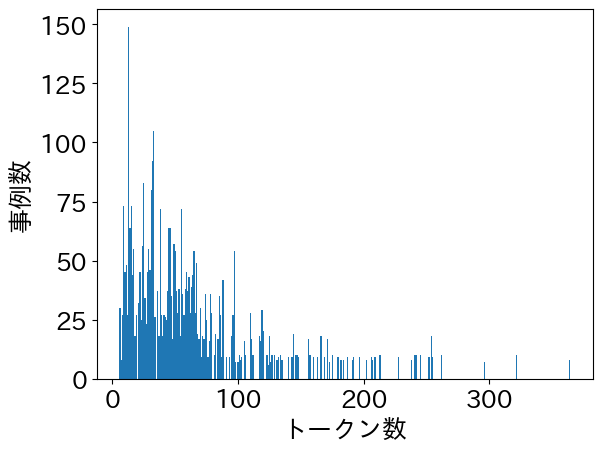

100%|██████████| 218/218 [00:00<00:00, 2632.16it/s]


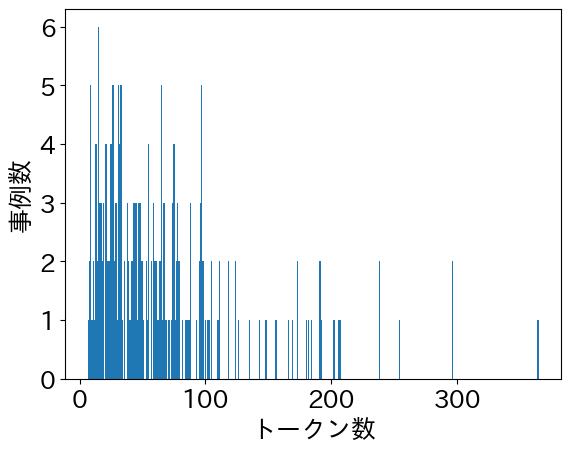

100%|██████████| 218/218 [00:00<00:00, 2530.21it/s]


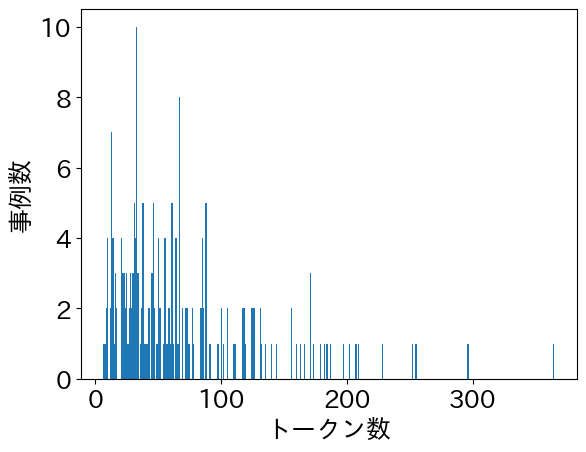

In [ ]:
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcParams["font.size"] = 18

def visualize_text_length(dataset: Dataset):
    """データセット中のテキストのトークン数の分布をグラフとして描画"""
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data["questions"]))
        length_counter[length] += 1
    # length_counterの値から棒グラフを描画する
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("トークン数")
    plt.ylabel("事例数")
    plt.show()

visualize_text_length(train_data)
visualize_text_length(eval_data)
visualize_text_length(test_data)

### データセットの前処理

In [ ]:
from transformers import BatchEncoding

class_label = dataset["labels"].unique()
label2id = {label: id for id, label in enumerate(class_label)}
id2label = {id: label for id, label in enumerate(class_label)}
print(label2id)

def preprocess_text_classification(examples: dict[str, list]) -> BatchEncoding:
    """バッチ処理用に修正"""
    encoded_examples = tokenizer(
        examples["questions"],  # バッチ処理なのでリストで渡される
        max_length=512,
        padding=True,
        truncation=True,
        return_tensors=None  # バッチ処理時はNoneを指定
    )

    # ラベルをバッチで数値に変換
    encoded_examples["labels"] = [label2id[label] for label in examples["labels"]]
    return encoded_examples


encoded_train_dataset = train_data.map(
    preprocess_text_classification,
    batched=True,  # これを追加
    remove_columns=train_data.column_names,
)

encoded_valid_dataset = eval_data.map(
    preprocess_text_classification,
    batched=True,  # これを追加
    remove_columns=eval_data.column_names,
)

encoded_test_dataset = test_data.map(
    preprocess_text_classification,
    batched=True,  # これを追加
    remove_columns=test_data.column_names,
)


Map:   0%|          | 0/3924 [00:00<?, ? examples/s]

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

### ミニバッチ構築

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### モデルの準備

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(class_label),
    label2id=label2id,
    id2label=id2label
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for param in model.parameters():
    param.data = param.data.contiguous()

### 訓練の実行

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="outputs",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    num_train_epochs=3,
    save_strategy="epoch",
    eval_strategy="epoch",  # evaluation_strategyを追加
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    # report_to="wandb"
)

In [ ]:
import numpy as np

def compute_accuracy(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_accuracy
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.399500,0.593179,0.871560
2,0.307200,0.104494,0.981651
3,0.095600,0.080331,0.972477


TrainOutput(global_step=369, training_loss=0.6007722735728028, metrics={'train_runtime': 414.8079, 'train_samples_per_second': 28.379, 'train_steps_per_second': 0.89, 'total_flos': 2214235808800128.0, 'train_loss': 0.6007722735728028, 'epoch': 3.0})

In [ ]:
from huggingface_hub import login

login(token=HF_TOKEN_WRITE)

In [ ]:
model.push_to_hub("hiroki-rad/bert-base-classification-ft")
tokenizer.push_to_hub("hiroki-rad/bert-base-classification-ft")

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/hiroki-rad/bert-base-classification-ft/commit/bdf83d504c8ae374bcc76ceb33dc351f12f475f3', commit_message='Upload tokenizer', commit_description='', oid='bdf83d504c8ae374bcc76ceb33dc351f12f475f3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/hiroki-rad/bert-base-classification-ft', endpoint='https://huggingface.co', repo_type='model', repo_id='hiroki-rad/bert-base-classification-ft'), pr_revision=None, pr_num=None)

### モデルの評価

In [ ]:
from pprint import pprint

eval_metrics = trainer.evaluate(encoded_test_dataset)
pprint(eval_metrics)

{'epoch': 3.0,
 'eval_accuracy': 0.9770642201834863,
 'eval_loss': 0.12136022001504898,
 'eval_runtime': 2.4739,
 'eval_samples_per_second': 88.12,
 'eval_steps_per_second': 2.83}


## 実際にファインチューニングしたモデルを使用する

In [ ]:
from transformers import pipeline

model_name = "hiroki-rad/bert-base-classification-ft"
classify_pipe = pipeline(model=model_name, device="cuda:0")

config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# 使用するデータセット
test_data = test_data.to_pandas()
test_data["labels"] = test_data["labels"].apply(lambda x: label2id[x])
test_data

,questions,labels
0,クマが海へ出向いてアザラシと交友関係を築き、最終には自宅へ戻るというストーリーを描いてください。,1
1,仮説: 2人の男女が、森の中を手をつないで歩いています。\nある前提からこの仮説が導けるかを...,3
2,A: 仕事は順調に進んでいますか?\nB: 大丈夫です。\nこの場合、Bさんの発言は「はい」...,0
3,仕事の熱意を取り戻すためのアイデアを5つ挙げてください。,0
4,古代ギリシャの文化、政治、社会における重要なポイントを3つ挙げ、それぞれについて具体的な事例...,3
...,...,...
213,以下の文を自然な日本語に直してください。\n「この薬は、痛みを軽減するために使用されますが、...,2
214,"RGB(255, 255, 0)は何色でしょうか?",2
215,あなたはゲーム開発チームのリーダーです。チームに新しいアクションパズルゲームの企画を依頼され...,7
216,クマが海辺に行き、アザラシと友達になり、最後に家に帰るというテーマに基づいた短編小説を書いて...,1


In [ ]:
class_label = dataset["labels"].unique()
label2id = {label: id for id, label in enumerate(class_label)}
id2label = {id: label for id, label in enumerate(class_label)}

results: list[dict[str, float | str]] = []

for i, example in tqdm(enumerate(test_data.itertuples())):
    # モデルの予測結果を取得
    model_prediction = classify_pipe(example.questions)[0]
    # 正解のラベルIDをラベル名に変換
    true_label = id2label[example.labels]

    results.append(
        {
            "example_id": i,
            "pred_prob": model_prediction["score"],
            "pred_label": model_prediction["label"],
            "true_label": true_label,
        }
    )

218it [00:02, 103.05it/s]


### 全体的な傾向の分析

In [ ]:
print(list(label2id.keys()))
label2id

['Task_Solution', 'Creative_Generation', 'Knowledge_Explanation', 'Analytical_Reasoning', 'Information_Extraction', 'Step_by_Step_Calculation', 'Role_Play_Response', 'Opinion_Perspective']


{'Task_Solution': 0,
 'Creative_Generation': 1,
 'Knowledge_Explanation': 2,
 'Analytical_Reasoning': 3,
 'Information_Extraction': 4,
 'Step_by_Step_Calculation': 5,
 'Role_Play_Response': 6,
 'Opinion_Perspective': 7}

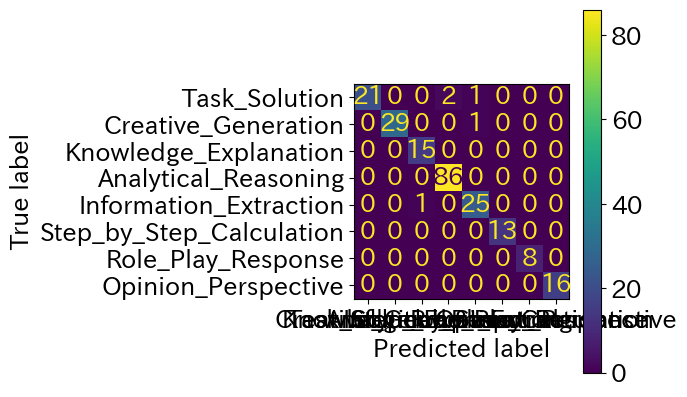

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

plt.rcParams["font.size"] = 18

# confusion matrixの作成
confusion_matrix = confusion_matrix(
    y_true=[result["true_label"] for result in results],
    y_pred=[result["pred_label"] for result in results],
    labels=list(label2id.keys()),
)
# 画像として表示
ConfusionMatrixDisplay(
    confusion_matrix, display_labels=list(label2id.keys())
).plot()

plt.tight_layout()

In [ ]:
confusion_matrix

array([[21,  0,  0,  2,  1,  0,  0,  0],
       [ 0, 29,  0,  0,  1,  0,  0,  0],
       [ 0,  0, 15,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 86,  0,  0,  0,  0],
       [ 0,  0,  1,  0, 25,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 13,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  8,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 16]])